In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import io

In [2]:
data = sp.io.loadmat('data/2013_DFC_contest.mat')

In [35]:
rgb_bands = [54,32,18]
hsi_rgb = data['hyper'][:,:,rgb_bands]
hsi_rgb = hsi_rgb/hsi_rgb.max()

pmin,pmax = np.percentile(hsi_rgb,(1,95),axis=(0,1))
hsi_rgb_pimped = hsi_rgb.copy()
for i in range(pmin.size):
    hsi_rgb_pimped[:,:,i] = (hsi_rgb[:,:,i]-pmin[i])/(pmax[i]-pmin[i])
hsi_rgb_pimped[hsi_rgb_pimped<0] = 0
hsi_rgb_pimped[hsi_rgb_pimped>1] = 1

In [3]:
groundtruth = np.load('groundtruth/groundtruth.npy')
groundtruth_info = np.load('groundtruth/groundtruth_info.npy',allow_pickle=True)
groundtruth_rgb = plt.imread('groundtruth/groundtruth.png')

In [4]:
groundtruth_info

array([{'class_name': 'grass_healthy', 'class_label': 1, 'class_color': array([  0, 205,   0])},
       {'class_name': 'grass_stressed', 'class_label': 2, 'class_color': array([127, 255,   0])},
       {'class_name': 'grass_synthetic', 'class_label': 3, 'class_color': array([ 46, 205,  87])},
       {'class_name': 'tree', 'class_label': 4, 'class_color': array([  0, 139,   0])},
       {'class_name': 'soil', 'class_label': 5, 'class_color': array([160,  82,  45])},
       {'class_name': 'water', 'class_label': 6, 'class_color': array([  0, 255, 255])},
       {'class_name': 'residential', 'class_label': 7, 'class_color': array([255, 255, 255])},
       {'class_name': 'commercial', 'class_label': 8, 'class_color': array([216, 191, 216])},
       {'class_name': 'road', 'class_label': 9, 'class_color': array([255,   0,   0])},
       {'class_name': 'highway', 'class_label': 10, 'class_color': array([139,   0,   0])},
       {'class_name': 'railway', 'class_label': 11, 'class_color': array

In [273]:
lidar = data['lidar']
print("L'image LiDAR est composée de %d lignes et %d colonnes "%(lidar.shape)+"au format %s"%lidar.dtype)
hsi_raw = data['hyper']
print("L'image hyperspectrale est composée de %d lignes, %d colonnes et %d bandes "%(hsi_raw.shape)
      +"au format %s"%hsi_raw.dtype)

L'image LiDAR est composée de 349 lignes et 1905 colonnes au format float32
L'image hyperspectrale est composée de 349 lignes, 1905 colonnes et 144 bandes au format uint16


In [274]:
lidar.shape, groundtruth.shape

((349, 1905), (349, 1905))

In [275]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# normalize the data
scaler = MinMaxScaler()

hsi_raw = hsi_raw#[:,:635,:]
lidar = lidar#[:,:635]
r,c,N = hsi_raw.shape
hsi = hsi_raw.reshape(r*c,N)

#fusion lidar and hsi for the whole image
allData = np.concatenate((hsi, lidar.reshape(-1, 1)), axis=1)

# we take only pixels with a grountruth known
hsi_train = hsi_raw[groundtruth != 0]
lidar_train = lidar[groundtruth != 0]

#normalize training sets
#lidar_train = lidar_train/lidar.max()
#hsi_train = hsi_train / hsi_raw.max()

print("lidar max: ", lidar.max())
print("hsi_raw max: ", hsi_raw.max())

# fusion lidar and hsi sets
x_train = np.concatenate((hsi_train, lidar_train.reshape(-1, 1)), axis=1)
y_train = groundtruth[groundtruth != 0]

#check shapes
allData.shape, hsi_train.shape, lidar_train.shape, x_train.shape, y_train.shape

lidar max:  70.85223
hsi_raw max:  65517


((664845, 145), (2832, 144), (2832,), (2832, 145), (2832,))

In [276]:
#chose the training set and the image type
x_train = hsi_train
toPredict = hsi

In [277]:
#### from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, stratify=y_train)

# Print the shape of the resulting training and validation sets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_train shape: (2265, 144)
y_train shape: (2265,)
x_val shape: (567, 144)
y_val shape: (567,)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier


#classifier = LinearSVC(random_state=1, max_iter=10000)
classifier = RandomForestClassifier(max_depth=20, random_state=1)
classifier = classifier.fit(x_train, y_train)

# evaluate the model on the validation set y_val
score = classifier.score(x_val, y_val)
print("Validation set score:", score)

(221615,)


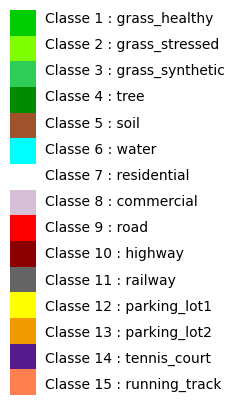

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 46. 205.  87.]
 [ 46. 205.  87.]
 [ 46. 205.  87.]
 ...
 [ 46. 205.  87.]
 [ 46. 205.  87.]
 [ 46. 205.  87.]]


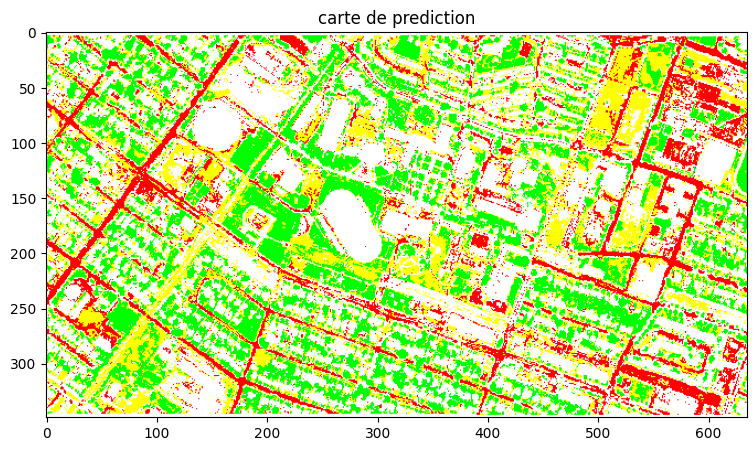

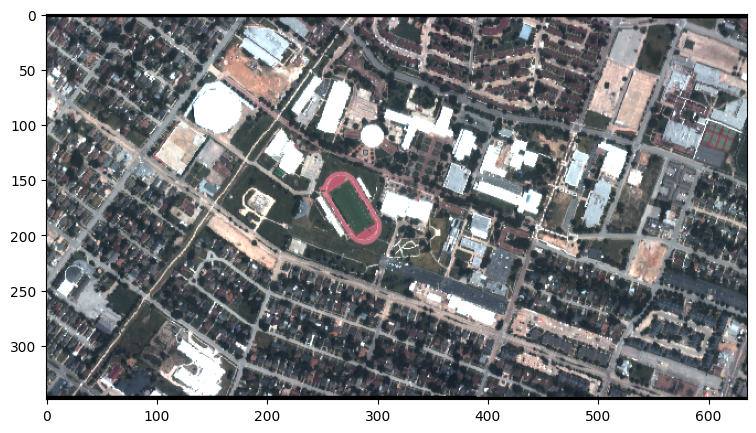

In [272]:
# predict for the whole image
prediction = classifier.predict(toPredict)
predictionRgb = np.zeros(shape=(prediction.shape[0], 3))
print(prediction.shape)

cls_rgb = []
for ii in groundtruth_info:
    cls_rgb.append(ii['class_color'])
cls_rgb = np.array(cls_rgb).reshape(15,-1,3)
plt.figure(figsize=(5,5))
plt.imshow(cls_rgb)
plt.axis('off')
for cls in range(15):
        plt.text(0.85,1.02*cls,'Classe %d : %s'%(cls+1,groundtruth_info[cls]['class_name']))
plt.show()

for i in range(len(prediction)):
    predictionRgb[i] = cls_rgb[prediction[i]-1]
print(predictionRgb)

plt.figure(figsize=(20,5))
plt.title('carte de prediction')
plt.imshow(predictionRgb.reshape((349,1905,3)))
plt.show()

plt.figure(figsize=(20,5))
plt.imshow(hsi_rgb_pimped)
plt.show()